In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import torch
import time
from tqdm.auto import tqdm

from chronos import ChronosPipeline
from darts import TimeSeries
from darts.datasets import AirPassengersDataset

from datasetsforecast.m3 import M3



In [49]:
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="mps",  # use "cpu" for CPU inference and "mps" for Apple Silicon
    torch_dtype=torch.bfloat16,
)

df = pd.read_csv('https://raw.githubusercontent.com/marcopeix/time-series-analysis/master/data/medium_views_published_holidays.csv')
df['ds'] = pd.to_datetime(df['ds'])

Y_df, *_ = M3.load(directory='./', group='Monthly')


100%|██████████| 1.76M/1.76M [00:01<00:00, 1.62MiB/s]
INFO:datasetsforecast.utils:Successfully downloaded M3C.xls, 1757696, bytes.
/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/datasetsforecast/m3.py:108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(class_group.freq)


In [54]:
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="mps",  # use "cpu" for CPU inference and "mps" for Apple Silicon
    torch_dtype=torch.bfloat16,
)

horizon = 12
batch_size = 12


actual = []
chronos_small_preds = []

start = time.time()
all_timeseries = [
    torch.tensor(sub_df["y"].values[:-horizon])
    for _, sub_df in Y_df.groupby("unique_id")
]
for i in tqdm(range(0, len(all_timeseries), batch_size)):
    batch_context = all_timeseries[i : i + batch_size]
    forecast = pipeline.predict(batch_context, horizon)
    predictions = np.quantile(forecast.numpy(), 0.5, axis=1)

    chronos_small_preds.append(predictions)

chronos_tiny_preds = np.concatenate(chronos_small_preds)
chronos_tiny_duration = time.time() - start
print(chronos_tiny_duration)

100%|██████████| 119/119 [01:17<00:00,  1.53it/s]

77.82558488845825


In [63]:
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-large",
    device_map="mps",
    torch_dtype=torch.bfloat16,
)

horizon = 12
batch_size = 12


actual = []
chronos_large_preds = []

start = time.time()
all_timeseries = [
    torch.tensor(sub_df["y"].values[:-horizon])
    for _, sub_df in Y_df.groupby("unique_id")
]
for i in tqdm(range(0, len(all_timeseries), batch_size)):
    batch_context = all_timeseries[i : i + batch_size]
    forecast = pipeline.predict(batch_context, horizon)
    predictions = np.quantile(forecast.numpy(), 0.5, axis=1)

    chronos_large_preds.append(predictions)

chronos_large_preds = np.concatenate(chronos_large_preds)
chronos_large_duration = time.time() - start
print(chronos_large_duration)


100%|██████████| 119/119 [05:20<00:00,  2.69s/it]

320.3509850502014


In [64]:
rows = {"unique_id": [], "chronos_tiny_pred": [], "chronos_large_pred": []}
for (name, _), tiny_pred, large_pred in zip(
    Y_df.groupby("unique_id"), chronos_tiny_preds, chronos_large_preds
):
    rows["unique_id"].extend([name] * horizon)
    rows["chronos_tiny_pred"].extend(tiny_pred)
    rows["chronos_large_pred"].extend(large_pred)
chronos_pred_df = pd.DataFrame(rows)
chronos_pred_df


,unique_id,chronos_tiny_pred,chronos_large_pred
0,M1,2825.453061,2698.751152
1,M1,2458.017411,3002.835693
2,M1,3116.867525,3053.516518
3,M1,2698.751049,2394.666508
4,M1,2635.400043,2888.804067
...,...,...,...
17131,M999,5219.398486,5219.398486
17132,M999,5202.058308,5236.738663
17133,M999,5202.058308,5219.398486
17134,M999,5219.398486,5236.738663


/var/folders/wr/rq4bfhkj6h56q645ftw89wtm0000gn/T/ipykernel_1738/1994365098.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=horizon, freq='M')


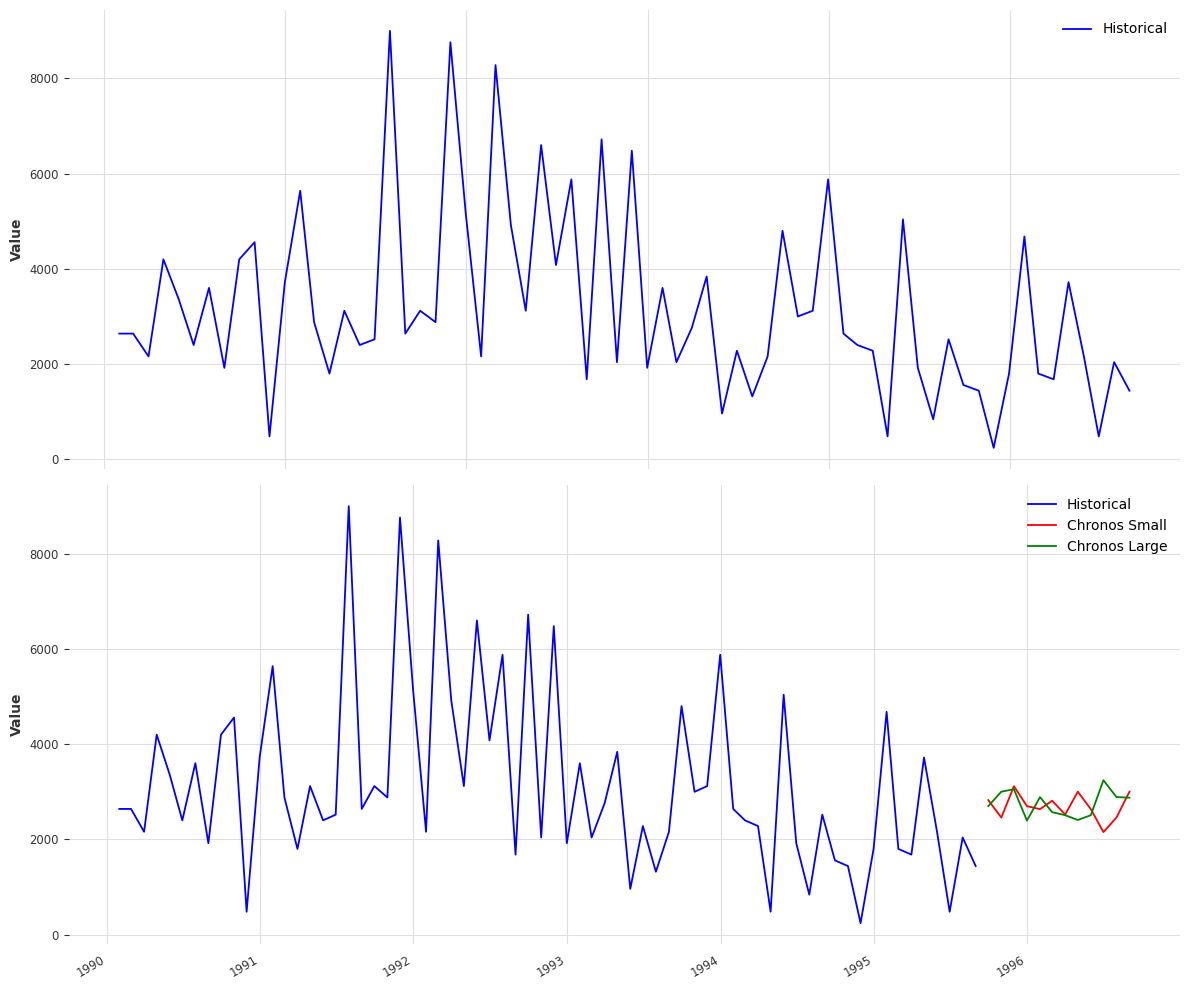

Chronos Small forecast: [2825.45306114 2458.01741091 3116.8675246  2698.75104885 2635.4000427
 2812.78277751 2521.36831405 3002.83579594 2635.4000427  2153.93276683
 2458.01741091 3002.83579594]
Chronos Large forecast: [2698.75115186 3002.83569293 3053.51651845 2394.66650778 2888.80406729
 2572.04913957 2508.69823643 2407.33658539 2508.69823643 3243.56943388
 2888.80406729 2876.13378365]
Forecast duration - Small: 77.83 seconds
Forecast duration - Large: 320.35 seconds


In [67]:
# Assuming chronos_tiny_preds and chronos_large_preds are already calculated
# and contain the predictions for all time series

# Select a specific time series (e.g., the first one)
series_index = 0
original_data = Y_df[Y_df['unique_id'] == Y_df['unique_id'].unique()[series_index]]

# Create date range for the forecast
last_date = original_data['ds'].iloc[-1]
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=horizon, freq='M')

fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, figsize=(12, 10))

# Plot original data
ax1.plot(original_data['ds'], original_data['y'], color='blue', label='Historical')
ax1.set_ylabel('Value')
ax1.legend()

# Plot forecasts
ax2.plot(original_data['ds'], original_data['y'], color='blue', label='Historical')
ax2.plot(forecast_dates, chronos_tiny_preds[series_index], color='red', label='Chronos Small')
ax2.plot(forecast_dates, chronos_large_preds[series_index], color='green', label='Chronos Large')
ax2.set_ylabel('Value')
ax2.legend()

# Format x-axis
for ax in [ax1, ax2]:
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.grid(True)

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

# Print some statistics
print(f"Chronos Small forecast: {chronos_tiny_preds[series_index]}")
print(f"Chronos Large forecast: {chronos_large_preds[series_index]}")
print(f"Forecast duration - Small: {chronos_tiny_duration:.2f} seconds")
print(f"Forecast duration - Large: {chronos_large_duration:.2f} seconds")

In [41]:
forecast = pipeline.predict(
    context=torch.tensor(df["#Passengers"]),
    prediction_length=12,
    num_samples=20,
)


/var/folders/wr/rq4bfhkj6h56q645ftw89wtm0000gn/T/ipykernel_1738/3326922210.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  context=torch.tensor(df["#Passengers"]),


In [66]:


forecast_index = range(len(df), len(df) + 12)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

plt.figure(figsize=(8, 4))
plt.plot(df["#Passengers"], color="royalblue", label="historical data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid()
plt.show()

KeyError: '#Passengers'

<Figure size 800x400 with 0 Axes>

In [34]:
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="cuda",
    torch_dtype=torch.bfloat16,
)

df = pd.read_csv("https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv")

# context must be either a 1D tensor, a list of 1D tensors,
# or a left-padded 2D tensor with batch as the first dimension
context = torch.tensor(df["#Passengers"])
embeddings, tokenizer_state = pipeline.embed(context)

AssertionError: Torch not compiled with CUDA enabled

In [21]:
forecast_series = TimeSeries.from_values(forecast.mean(dim=1)[0])


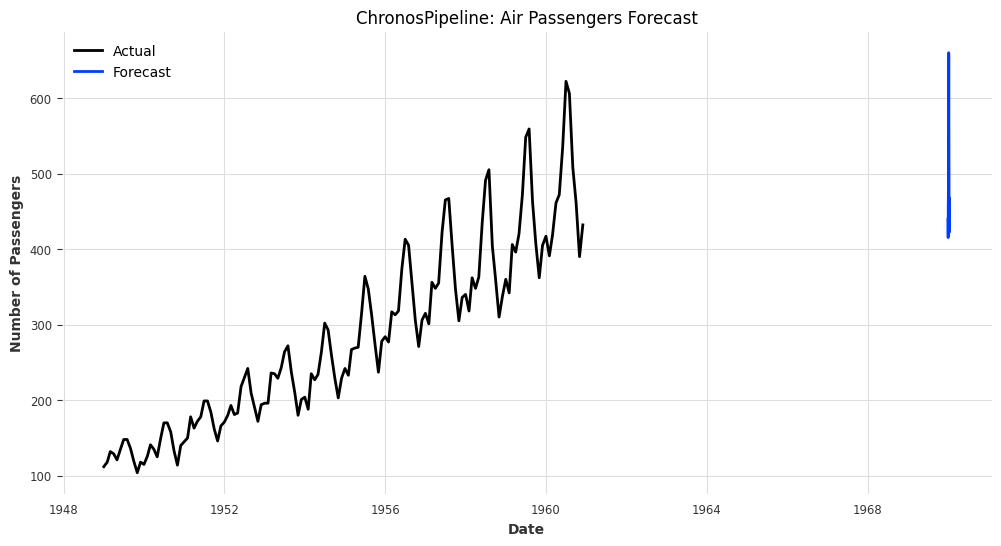

Forecast mean: tensor([439.7647, 415.3105, 456.5128, 471.3086, 490.7281, 565.8374, 659.8525,
        656.8729, 551.7609, 490.2144, 421.9892, 466.8903])
Forecast std: tensor([ 6.7993,  9.3317, 13.9419, 15.0608, 15.0950, 21.2963, 16.1245, 24.1798,
        24.8706, 20.7593, 22.4248, 19.0757])


In [22]:
plt.figure(figsize=(12, 6))
air_passengers.plot(label='Actual')
forecast_series.plot(label='Forecast')
plt.title('ChronosPipeline: Air Passengers Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

# Print some statistics
print(f"Forecast mean: {forecast.mean(dim=1)[0]}")
print(f"Forecast std: {forecast.std(dim=1)[0]}")

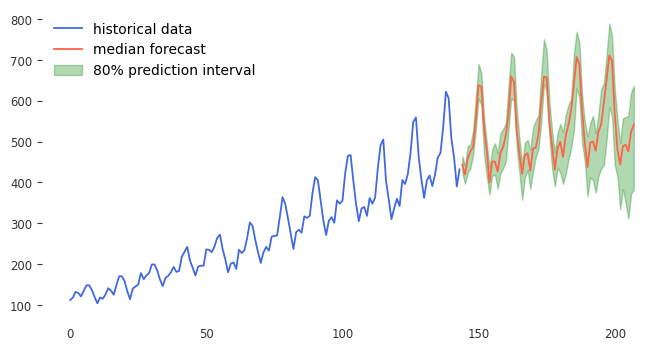

In [77]:
pipeline = ChronosPipeline.from_pretrained(
  "amazon/chronos-t5-large",
  device_map="mps",
  torch_dtype=torch.bfloat16,
)

df = pd.read_csv("https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv")

# context must be either a 1D tensor, a list of 1D tensors,
# or a left-padded 2D tensor with batch as the first dimension
context = torch.tensor(df["#Passengers"])
prediction_length = 64
forecast = pipeline.predict(context, prediction_length, limit_prediction_length=False)  # shape [num_series, num_samples, prediction_length]

# visualize the forecast
forecast_index = range(len(df), len(df) + prediction_length)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

plt.figure(figsize=(8, 4))
plt.plot(df["#Passengers"], color="royalblue", label="historical data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(forecast_index, low, high, color="green", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid()
plt.show()
